In [198]:
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TiDEModel
from darts.metrics import rmse, mape, mae
import matplotlib.pyplot as plt
import numpy as np


In [199]:
# Tải dữ liệu cổ phiếu AAPL từ Yahoo Finance
data = pd.read_csv('../../Dataset/AAPL.csv')
# data = pd.read_csv('../../Dataset/GOOG.csv')
# data = pd.read_csv('../../Dataset/MSFT.csv')

# Chỉ giữ lại cột 'Close'
df = data[['Close']]

In [200]:
# Chuyển đổi DataFrame thành TimeSeries
series = TimeSeries.from_dataframe(df)

# Chuẩn hóa dữ liệu
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

In [201]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(series_scaled))
test_size = int(0.3 * len(series_scaled))

train = series_scaled[:train_size]
test =  series_scaled[train_size:]

In [202]:
# train_size = int(0.8 * len(series_scaled))
# test_size = int(0.2 * len(series_scaled))

# train = series_scaled[:train_size]
# test =  series_scaled[train_size:]

In [203]:
# train_size = int(0.9 * len(series_scaled))
# test_size = int(0.1 * len(series_scaled))

# train = series_scaled[:train_size]
# test =  series_scaled[train_size:]

In [204]:
# Khởi tạo model TiDE
model = TiDEModel(
    input_chunk_length=100,  # Sử dụng 100 ngày giao dịch làm đầu vào
    output_chunk_length=30,  # Dự báo cho 90 ngày giao dịch tiếp theo
    hidden_size=50,
    random_state=1
)

# Huấn luyện model
model.fit(train)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 12.7 K
4 | decoders         | Sequential       | 51.5 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 3.0 K 
------------------------------------------------------
67.8 K    Trainable params
0         Non-trainable params
67.8 K    Total params
0.271     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 31/31 [00:00<00:00, 59.20it/s, train_loss=0.00155] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 31/31 [00:00<00:00, 59.20it/s, train_loss=0.00155]


TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=50, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=100, output_chunk_length=30, random_state=1)

In [205]:
# Dự đoán trên tập kiểm tra
test_pred = model.predict(n=len(test), series=train)

# Dự đoán 30 ngày tiếp theo
# predict30days = model.predict(n=len(test)+30)
# predict60days = model.predict(n=len(test)+60)
predict90days = model.predict(n=len(test)+90)

# Đảo ngược chuẩn hóa
train = scaler.inverse_transform(train)
test = scaler.inverse_transform(test)
test_pred = scaler.inverse_transform(test_pred)
# predict30days = scaler.inverse_transform(predict30days)
# predict60days = scaler.inverse_transform(predict60days)
predict90days = scaler.inverse_transform(predict90days)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.78it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.82it/s]


In [206]:
# Tính toán các chỉ số đánh giá
rmse_value = rmse(test, test_pred)
mape_value = mape(test, test_pred)
mae_value = mae(test, test_pred)

print(f"RMSE: {rmse_value}")
print(f"MAPE: {mape_value}")
print(f"MAE: {mae_value}")

RMSE: 20.968999323156634
MAPE: 10.386112137829492
MAE: 18.17045670003347


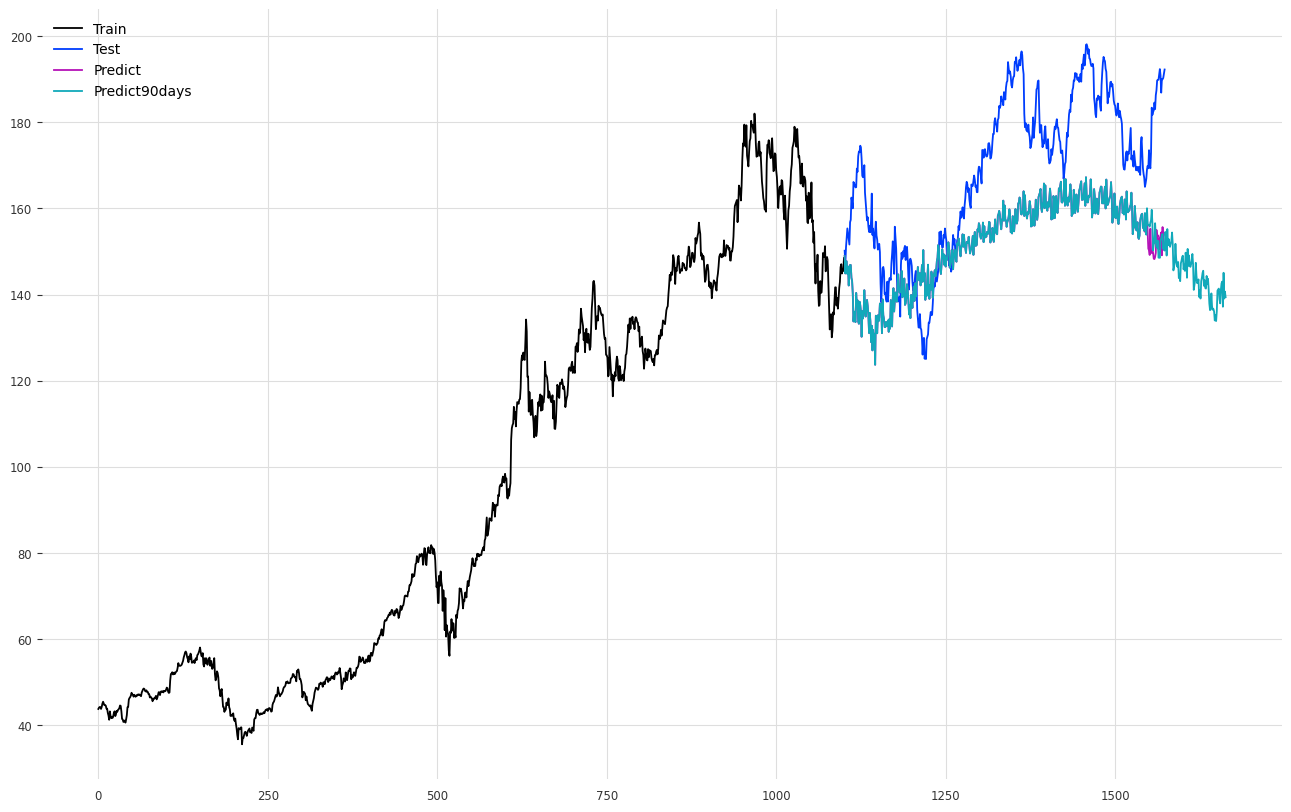

In [207]:
plt.figure(figsize=(16,10))
train = train.pd_dataframe()
test = test.pd_dataframe()
test_pred = test_pred.pd_dataframe()
# predict30days = predict30days.pd_dataframe()
# predict60days = predict60days.pd_dataframe()
predict90days = predict90days.pd_dataframe()

plt.plot(train.index, train['Close'])
plt.plot(test.index, test['Close'])
plt.plot(test_pred.index, test_pred['Close'])
# plt.plot(predict30days.index, predict30days['Close'])
# plt.plot(predict60days.index, predict60days['Close'])
plt.plot(predict90days.index, predict90days['Close'])

# plt.legend(['Train','Test','Predict','Predict30days'])
# plt.legend(['Train','Test','Predict','Predict60days'])
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()